# Misc dataset

In [1]:
B = 3
f = 0.7
Tb = 1000
kb = 0.2
lb = 5
Tt = 10000
kt = 0.2
lt = 10
s = 0.05
std_dev_multiplier = 1
D_red = 10
Tt_red = 10000
kt_red = 0.2
lt_red = 10
s_red = 0.05

In [2]:
from model.graph_mcmc import Graph_MCMC

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
graph = Graph_MCMC()
graph.read_from_ns("polbooks") #"soc_net_comms/amazon"

In [5]:
graph.print_info()
graph.rename_property("label", "_label")

Graph with N=105 nodes, E=441 edges and D=2 vertex features for training


True

In [6]:

graph.convert_props_to_flags()

In [7]:
graph.list_props()

name            (graph)   (type: string, val: polbooks)
description     (graph)   (type: string, val: A network of books about U.S.
                                              politics published close to the
                                              2004 U.S. presidential election,
                                              and sold by Amazon.com. Edges
                                              between books represent frequent
                                              copurchasing of those books by
                                              the same buyers. The network was
                                              compiled by V. Krebs and is
                                              unpublished.)
citation        (graph)   (type: string, val: ['V. Krebs, unpublished,
                                              http://www.orgnet.com/,
                                              http://www.orgnet.com/'])
url             (graph)   (type: string, val: http://

In [8]:
graph.partition(B_min=B, B_max=B)

Performing inference...
Current bracket: (3, 3, 3) (1272.5448770571568, 1272.5448770571568, 1272.5448770571568)
Current bracket: (3, 3, 3) (1272.5448770571568, 1272.5448770571568, 1272.5448770571568)
Bisect at B = 3 with S = 1272.544877057157
Best result: B = 3, S = 1272.544877057157
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f2a947070a0, at 0x7f2a2291cb20>

In [9]:
av_dl = graph.mcmc(num_iter=Tb)

100%|██████████| 1000/1000 [00:00<00:00, 3165.71it/s]


Drawing soft partition


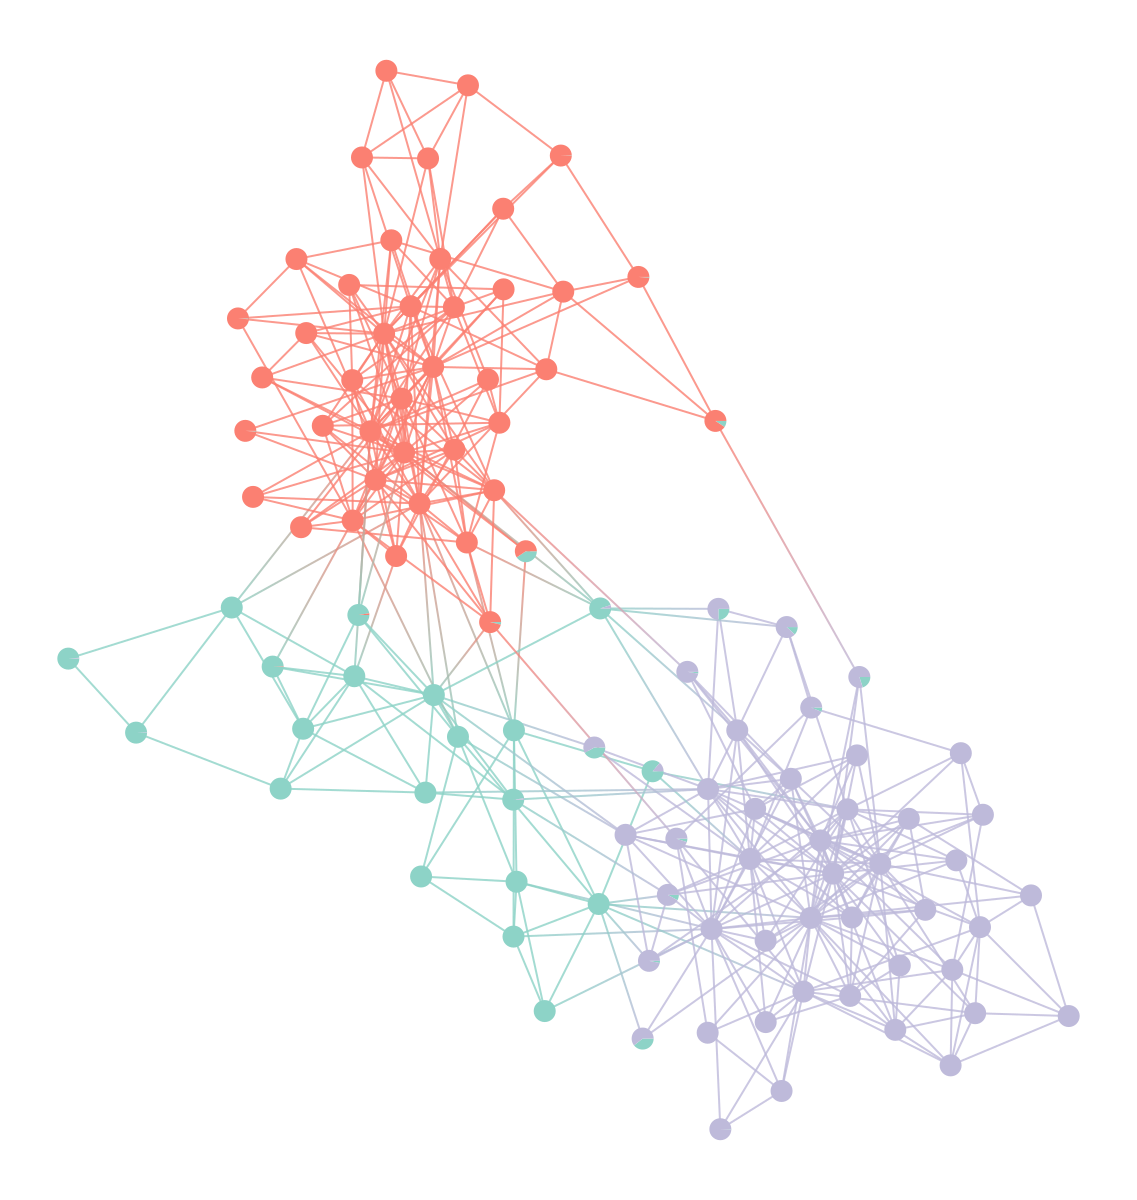

In [10]:
#graph.draw(gen_layout=False, size=10, output="polbooks-graph.png")
graph.draw(gen_layout=False, size=10)

Drawing block adjacency matrix $e_{rs}$


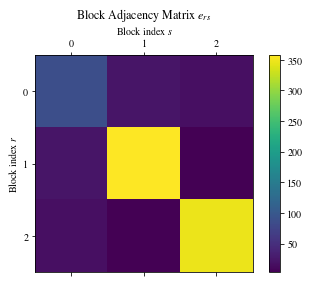

In [11]:
graph.plot_matrix()

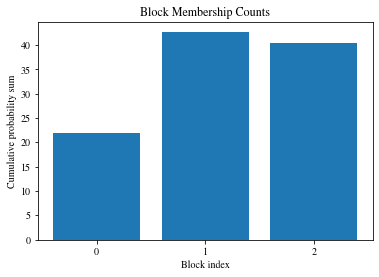

In [12]:
graph.plot_posterior_props()

## Train classifier

In [13]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [14]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [15]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=f)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [16]:
classifier = SoftmaxNeuralNet(layers_size=[D, B])
classifier.perform_mala(X_train, Y_train, step_scaling=s, num_iter=Tt, verbose=True)

100%|██████████| 10000/10000 [00:09<00:00, 1069.49it/s]Sample accept ratio: 94.32000000000001%
Train. set accuracy: 86.3013698630137%



(0.9432, 0.863013698630137)

## Interpret results

### Thinning

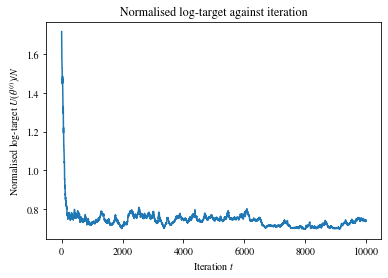

0.7445829353970459

In [17]:
classifier.plot_U()

In [18]:
classifier.thin_samples(burn_in=kt, thin_factor=lt)

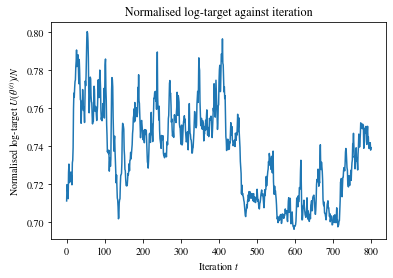

0.7366957869112883


In [19]:
u_mean = classifier.plot_U()
print(u_mean)

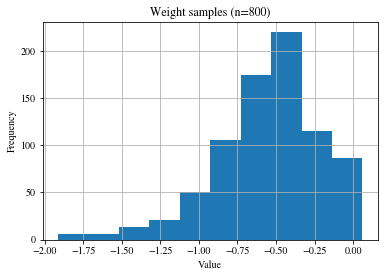

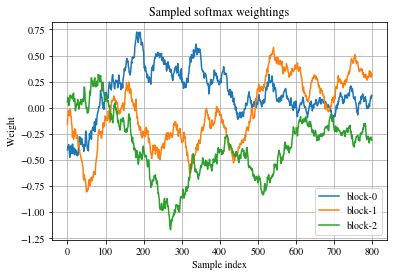

In [20]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [21]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 0.49968648363650503, Test loss: 0.67143914268553


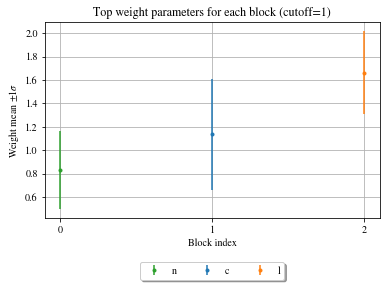

In [22]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Max cutoff: 0.7635916482462581
Discarded 1 features


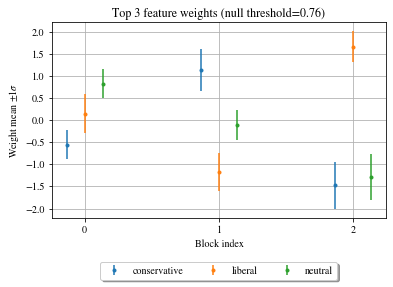

In [23]:
names = list(graph.get_feature_names())
names = ["conservative", "liberal", "neutral"]
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=std_dev_multiplier, legend=True, D_reduced=D_red)

In [24]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B])
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=s_red, num_iter=Tt, verbose=True)

100%|██████████| 10000/10000 [00:09<00:00, 1067.86it/s]Sample accept ratio: 94.19999999999999%
Train. set accuracy: 86.3013698630137%



(0.942, 0.863013698630137)

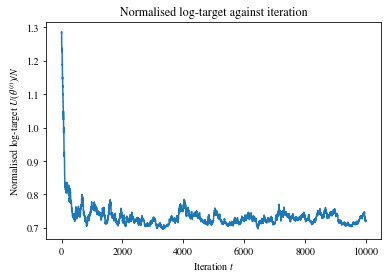

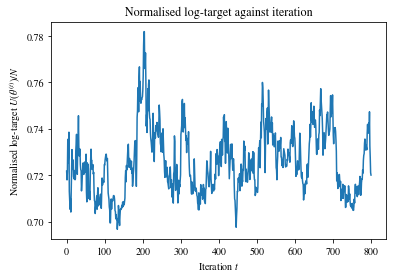

0.7258317168036392

In [25]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in=kt_red, thin_factor=lt_red)
reduced_classifier.plot_U()

In [26]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 0.5078564666840447, Test loss: 0.6813320097532123


In [27]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 2.2494762697676864
Training loss: 0.49968648363650503, Test loss: 0.67143914268553
D': 3
REDUCED CLASSIFIER -- Training loss: 0.5078564666840447, Test loss: 0.6813320097532123
